# Neuron value coding

This project formed part of my paper characterising the link between neural network activity and the value of items ([link](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1)).The original data was collected by other researchers (available [here](https://crcns.org/data-sets/pfc/pfc-7/about-pfc-7)), and I have conducted the analysis of it.

Here, we'll analyse firing rates from ACC neurons while looking at an image when there are three other images in the peripheral vision. Images are drawn from a set of 10, each of which has a unique value associated with it. We will ask whether the value of each image has an effect on the neural firing rates.

---
## Data visualisation

Load in the required modules and data. 

In [1]:
import numpy as np
import plot
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm

y = np.load('y.npy')  # Neuron firing rates [numNeurons x numTrials x Time]
x = np.load('x.npy')  # Value of 4 cues on each trial [numNeurons x numCues x numTrials]
time = range(-100, 1000, 10)  # Data is binned into 10 ms windows
tp = 25  # The example timepoint we shall use

Let's choose a random neuron and see how it's firing changes as a function of the image that they look at

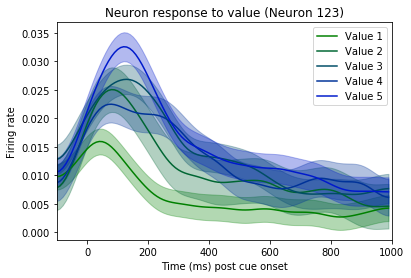

In [2]:
ineuron = 123
yy, xx = y[ineuron], x[ineuron, 0]

averages = [np.mean(yy[xx==val], axis=0) for val in np.unique(xx)]
sems = [np.std(yy[xx==val]) / np.sqrt(len(yy[xx==val])) for val in np.unique(xx)]

plot.plot1(averages, sems);
plt.title(f'Neuron response to value (Neuron {ineuron})');

Cool, it looks like this neuron is increasing its firing rate for higher value items.

## Multiple linear regression

Lets model this using multiple linear regression. Our first model will just contain the value of the image looked at and an intercept parameter.

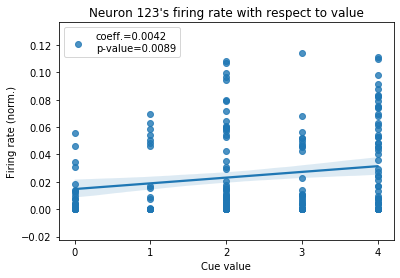

In [3]:
design_matrix = np.vstack((np.ones(len(xx)), xx)).T  # Add intercept
m = sm.OLS(yy[:, tp], design_matrix).fit()  # Fit the model
betas, pvals = m.params, m.pvalues  # Extract our statistics

#Plot 
sb.regplot(xx, yy[:, tp], label=f'coeff.={np.round(m.params[1], 4)}\np-value={np.round(pvals[1], 4)}')
plt.xlabel('Cue value'), plt.ylabel('Firing rate (norm.)'); plt.legend()
plt.xticks(range(5));
plt.title(f'Neuron {ineuron}\'s firing rate with respect to value');

We can see that the coefficient is very significant (p<.001) and thus value had a strong effect on this neurons firing rate. The best practice with time data is to conduct analysis over all time points (if feasible). Now we want to perform our analysis over all time points, which is expensive if using the complex statsmodels package. To do this efficiently, we'll vectorise our estimation of coefficients by using the the dot product of the pseudoinverse of x to perform OLS.

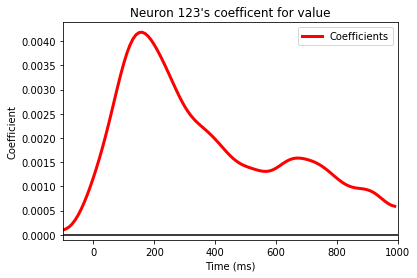

In [4]:
def reg(x, y):
    return np.dot(np.linalg.pinv(x), y)

coeffs = reg(design_matrix, yy)

#Plot
f, ax = plt.subplots(1)
ax.plot(time, coeffs[1], lw=3, label='Coefficients', c='red'); ax.axhline(0, c='k')
ax.set_ylabel('Coefficient'); ax.set_xlabel('Time (ms)'); ax.set_xlim(-100, 1000)
ax.legend(); ax.set_title(f'Neuron {ineuron}\'s coefficent for value');

Cool we can see a nice clear peak where the coefficients increase. Just examining raw coefficients isn't a good measure of our model's fit, however, so we'll use the coefficient of partial determination (Rsquared) instead. This represents the percentage of additional variance that is explained by the model when adding in our parameter. Again, we'll create a vectorised function to enable us to do it efficiently.

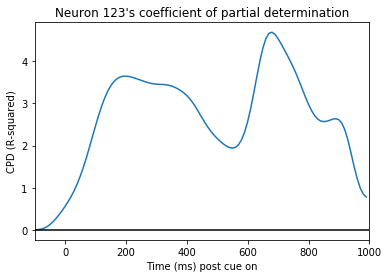

In [5]:
def cpd(x, y, i):
    bs = reg(x, y)  # Get coefficients
    pred = np.dot(x, bs)  # Get yhat
    r = y - pred  # Get residuals (SSE)
    
    # Now get SSE without that column in our design matrix
    xred = np.delete(x, i, axis=1)  # Remove column
    bs2 = reg(xred, y)  # Get coeffs
    predred = np.dot(xred, bs2)  # Get yhat
    rred = y - predred  # Get residuals (SSE)
    
    # Calculate percentage of additional variance explained by the parameter
    rsqr =  (np.sum(np.square(rred), axis=0) - np.sum(np.square(r), axis=0)) / np.sum(np.square(rred), axis=0)
    
    rsqr *= 100 # Convert from fraction to percentage
    
    return rsqr

rsqr = cpd(design_matrix, yy, 1)
plt.plot(time, rsqr); plt.axhline(0, c='k'); plt.ylabel('CPD (R-squared)');
plt.xlabel('Time (ms) post cue on'); plt.xlim(-100, 1000)
plt.title(f'Neuron {ineuron}\'s coefficient of partial determination'); 

Great, we can  see that value explains a (relatively) large proportion of the variance for a long time after the cue first came on. Lets now compute the CPD for all our neurons and look at the average effecct over the network. 

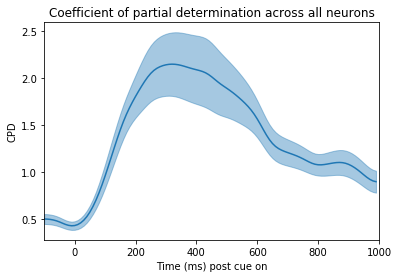

In [6]:
rsqrs = np.empty((len(y), y.shape[-1]))
for ineur, (yneur,xneur) in enumerate(zip(y, x[:, 0])):
    design_matrix = np.vstack((np.ones(len(xneur)), xneur)).T
    rsqrs[ineur] = cpd(design_matrix, yneur, 1)

# Plot
avg, sem = np.mean(rsqrs,axis=0), np.std(rsqrs,axis=0) / np.sqrt(len(rsqrs))
f, ax= plt.subplots(1); ax.set_xlim(-100, 1000)
ax.plot(time, avg); ax.fill_between(time, avg-sem, avg+sem, color='C0', alpha=0.4)
plt.ylabel('CPD');plt.xlabel('Time (ms) post cue on');
plt.title(f'Coefficient of partial determination across all neurons'); 

As with our individual neuron, we can see the activity of this neural activity is strongly modulated by the value of the item they look at. Let's now look at the effect of our other three parameters, the value of the other 3 other cues that were present in the peripheral vision. 

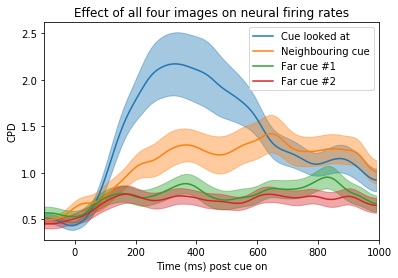

In [7]:
rsqrs = np.empty((4, len(y), y.shape[-1]))
for ineur, (yneur,xneur) in enumerate(zip(y, x)):
    
    design_matrix = np.vstack((np.ones(len(xneur[0])), xneur)).T
    
    for iparam in range(4):
        rsqrs[iparam, ineur] = cpd(design_matrix, yneur, iparam+1)

avgRsqrs = np.mean(rsqrs, axis=1)  # Average Rsqr across neurons

plot.avgsem(rsqrs);
plt.title('Effect of all four images on neural firing rates');

Awesome, these neurons are simultaneously representing the value of both the cue that's looked at as well as the other cues in the peripheral vision. 

## Permutation testing
Lets now statistically test whether all four parameters are actually significant in their effect on the firing rates. A quick and rigorous way to do this is using permutation testing. Lets compute the null distribution of the CPD and compare it to our data. We shall shuffle the y-data across trials, so as to preserve both autocorrelations over time, and correlations between our different  coefficients.

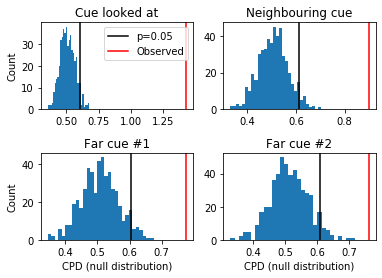

In [8]:
numperms = 500
nullDistribution = np.empty((4, len(y), y.shape[-1], numperms))

for ineur, (yneur,xneur) in enumerate(zip(y, x)):  # For each neuron
    
    design_matrix = np.vstack((np.ones(len(xneur[0])), xneur)).T
    
    for iperm in range(numperms):  # For each permutation
    
        np.random.shuffle(yneur)  # Shuffle the y data
        
        # recompute CPD
        for iparam in range(4):
            nullDistribution[iparam, ineur, :, iperm] = cpd(design_matrix, yneur, iparam+1)
            
avgNullDist = np.mean(nullDistribution, axis=1)  # Average across neurons 
sortNullDist = np.sort(avgNullDist, axis=-1)  # Sort array 
thresholds = sortNullDist[:, :, int(numperms*0.95)]  # Find 95th percentile (p=0.05)

plot.hist(avgNullDist, thresholds, avgRsqrs, tp);

Great, we can see that, for this time point, all four CPD values are outside of the null distribution, even for the cues in the distant peripheral vision. Therefore, there was a significant effect of all four cues on the firing rate of our neurons. Lets have a look at this effect over time.

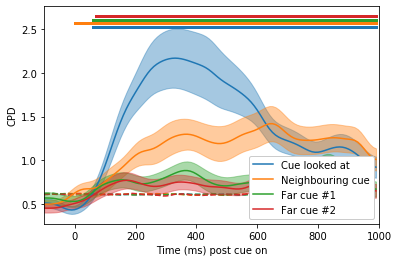

In [11]:
f, ax = plot.avgsem(rsqrs)
for iparam, (thresh, obs) in enumerate(zip(thresholds, avgRsqrs)):
    
    sig = obs > thresh  # Periods where we cross our threshold
    
    sig = np.array(sig,dtype=float) * (2.53 +(0.04*iparam))
    sig[sig==0]=np.nan;ax.plot(time, sig,c=f'C{iparam}', lw=3) 
    ax.plot(time,thresh,ls='--',c=f'C{iparam}', zorder=-1)
ax.legend(loc='lower right', framealpha=1);

Cool! So we can see that despite the fact that two of the cues are far away from where the monkey was looking, they still had a significant influence on the firing rate of the neurons that we are modelling. Hence, the neural network within ACC is capable of responding to the value of four distinct items simultaneously ([full paper](https://www.biorxiv.org/content/10.1101/2021.10.08.463476v1)).